# Модуль В. Обработка и анализ текстовых данных (инвариант)

# 1. Постановка задачи

Необходимо из описаний вакансий вычленить ключевые навыки. Навыки - конкретные умения и требования, которые предъявляет работодатель к соискателю. 
С помощью алгоритмов анализа естественного языка необходимо провести предварительную обработку данных, провести кластеризацию и классификацию выделенных навыков в близкие по смыслу категории. 
Провести анализ полученных классов навыков: определить наиболее востребованные и наименее востребованные навыки для выбранной группы вакансий; определить наиболее высокооплачиваемые навыки; определить региональную специфику востребованных навыков.

Результат модуля: 
1. Таблица в формате xlsx с классом навыков, его содержанием и частотой встречаемости. 
2. Аналитическая записка в формате docx с основными выводами

# 2. Получение данных о вакансиях

## 2.1. Парсинг данных

Возьмем существующий датасет с нашими вакансиями и спарсим дополнительные вакансии для нашего датасета.

In [1]:
# Библиотека для работы с HTTP-запросами. Будем использовать ее для обращения к API HH
import requests

# Пакет для удобной работы с данными в формате json
import json

# Модуль для работы со значением времени
import time

# Модуль для работы с операционной системой. Будем использовать для работы с файлами
import os

# Модуль для работы с датафреймами
import pandas as pd

# Модули для отчистки и вывода информации
from IPython.display import clear_output
from IPython.display import display

# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

### 2.1.1. Получение информаций со страниц (10 страниц - 1 регион)

Получим страницы в виде json файлов через API hh.ru. Можете ознакомиться с документацией API HH на их сайте.

In [7]:
# Создаём папку в корне для удобной работы с файлами
if not os.path.exists('./docs2'):
    os.makedirs('./docs2')
# Создаём папку в docs для удобной работы с файлами (страницы)
if not os.path.exists('./docs2/pagination2'):
    os.makedirs('./docs2/pagination2')

def getPage_Reg2(page = 0):
    """
    Создаем метод для получения страницы со списком вакансий.
    Аргументы:
        page - Индекс страницы, начинается с 0. Значение по умолчанию 0, т.е. первая страница
    """
    
    # Справочник для параметров GET-запроса
    params = {
        'text': 'NAME:Аналитик', # Текст фильтра. В имени должно быть слово "Аналитик"
        'area': 2, # Санкт-Питербург
        'page': page, # Индекс страницы поиска на HH
        'per_page': 100 # Кол-во вакансий на 1 странице
    }
    
    
    req = requests.get('https://api.hh.ru/vacancies', params) # Посылаем запрос к API
    data = req.content.decode() # Декодируем его ответ, чтобы Кириллица отображалась корректно
    req.close()
    return data

# Считываем первые 2000 вакансий
for page in range(0, 20):
    
    # загружаем json
    jsObj = json.loads(getPage_Reg2(page))

    # Сохраняем файлы в папку {путь до текущего документа со скриптом}\docs\pagination
    # Определяем количество файлов в папке для сохранения документа с ответом запроса
    # Полученное значение используем для формирования имени документа
    nextFileName = './docs2/pagination2/{}.json'.format(len(os.listdir('./docs2/pagination2')))
    
    # Создаем новый документ, записываем в него ответ запроса, после закрываем
    f = open(nextFileName, mode='w', encoding='utf8')
    f.write(json.dumps(jsObj, ensure_ascii=False))
    f.close()
    
    # Проверка на последнюю страницу, если вакансий меньше 5000
    if (jsObj['pages'] - page) <= 1:
        break
    
    # Необязательная задержка, но чтобы не нагружать сервисы hh, оставим. 5 сек мы может подождать
    time.sleep(0.25)
    
print('Старницы поиска собраны')

Старницы поиска собраны


### 2.1.2. Получение вакансий из файлов страниц

In [9]:
# Создаём папку в docs для удобной работы с файлами (вакансии)
if not os.path.exists('./docs2/vacancies2'):
    os.makedirs('./docs2/vacancies2')
    
# Получаем перечень ранее созданных файлов со списком вакансий и проходимся по нему в цикле 
for fl in os.listdir('./docs2/pagination2'):
    
    # Открываем файл, читаем его содержимое, закрываем файл
    f = open('./docs2/pagination2/{}'.format(fl), encoding='utf8')
    jsonText = f.read()
    f.close()
    
    # Преобразуем полученный текст в объект справочника
    jsonObj = json.loads(jsonText)
    
    # Получаем и проходимся по непосредственно списку вакансий
    for v in jsonObj['items']:
        
        # Обращаемся к API и получаем детальную информацию по конкретной вакансии
        req = requests.get(v['url'])
        data = req.content.decode()
        req.close()
        
        # Создаем файл в формате json с идентификатором вакансии в качестве названия
        # Записываем в него ответ запроса и закрываем файл
        fileName = './docs2/vacancies2/{}.json'.format(v['id'])
        f = open(fileName, mode='w', encoding='utf8')
        f.write(data)
        f.close()
        
        time.sleep(0.25)
        
print('Вакансии собраны')

Вакансии собраны


### 2.1.3. Удаление файлов, не прошедших проверку (где требуется captcha)


Обычно такие файлы весят меньше 2 КБ, поэтому будем удалять именно их. (Можно убедиться что файлы у которых вес меньше 2 КБ нет нужных нам параметров таких как описание, название и т.д., вы можете открыть файл в блокноте и убедиться в этом сами). Кстати, таких файлов довольно много, вообще это можно обойти используя несколько прокси, но для этого нужны выделенные апи разных стран, так что спарсим сколько сможем, думаю из 5к вакансии останется где то 1-2к.

In [11]:
# Метод для удаления файлов, которые запрашивают captcha.
def delete_files_smaller_than_2kb(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and os.path.getsize(file_path) < 2 * 1024:
            os.remove(file_path)

# Используем наш метод
delete_files_smaller_than_2kb('./docs2/vacancies2')

Теперь проверим сколько у нас получилось валидных вакансий

In [2]:
cnt_docs = len(os.listdir('./docs/vacancies'))
print(cnt_docs)

1202


В итоге получилось 1202 вакансий

### 2.1.4. Формирование датафрейма

Теперь из наших файлов можно сформировать датасет с нужной информацией по вакансиям

In [3]:
IDs = [] # Список идентификаторов вакансий
names = [] # Список наименований вакансий
descriptions = [] # Список описаний вакансий
experience = [] # Список требуемого опыта вакансий
company_name = [] # Список компаний вакансий
skills_vac = [] # Список идентификаторов вакансий
skills_name = [] # Список названий навыков
schedule_day = [] # Список графика работы вакансий
address = [] # Список городов вакансий
salary = [] # Список зарплат (от) вакансий
date_public = [] # Список дат публикации вакансий

# В выводе будем отображать прогресс
# Для этого узнаем общее количество файлов, которые надо обработать
# Счетчик обработанных файлов установим в ноль
cnt_docs = len(os.listdir('./docs/vacancies'))
i = 0

# Проходимся по всем файлам в папке vacancies
for fl in os.listdir('./docs/vacancies'):
    
    # Открываем, читаем и закрываем файл
    f = open('./docs/vacancies/{}'.format(fl), encoding='utf8')
    jsonText = f.read()
    f.close()
    
    # Текст файла переводим в справочник
    jsonObj = json.loads(jsonText)
    
    # Заполняем списки
    IDs.append(jsonObj['id'])
    names.append(jsonObj['name'])
    descriptions.append(jsonObj['description'])
    schedule_day.append(jsonObj['schedule']['name'])
    experience.append(jsonObj['experience']['name'])
    
    if(jsonObj['department'] == None):
        company_name.append(None)
    else:
        company_name.append(jsonObj['department']['name'])
    
    if (jsonObj['salary'] == None):
        salary.append(None)
    else:
        salary.append(jsonObj['salary']['from'])

    # Т.к. был выбран первый регион, зададим автоматом регион московская область
    # Остальные регионы будут взяты со второго способа
    address.append("Москва")
    
    date_public.append(jsonObj['published_at'])
    
    # Т.к. навыки хранятся в виде массива, то проходимся по нему циклом
    skills_oner = []
    if len(jsonObj['key_skills']) == 0:
        skills_name.append("Не указано")
    else: 
        for skl in jsonObj['key_skills']:
            skills_oner.append(skl['name'])
            
        skills_string = '; '.join(skills_oner)
        skills_name.append(skills_string)
    
    # Увеличиваем счетчик обработанных файлов на 1, очищаем вывод ячейки и выводим прогресс
    i += 1
    clear_output(wait=True)
    display('Готово {} из {}'.format(i, cnt_docs))

'Готово 1202 из 1202'

Сформируем датафрейм из наших получившихся списков.

In [4]:
df = pd.DataFrame({'id': IDs, 'company': company_name, 'name': names, 'description': descriptions, 'skills': skills_name, 'date_public': date_public, 'schedule': schedule_day, 'region': address, 'experience': experience, 'salary': salary})

In [5]:
df.head(5)


,id,company,name,description,skills,date_public,schedule,region,experience,salary
0,73013752,None,Аналитик в планово-диспетчерский отдел,"<strong>Обязанности:</strong> <ul> <li>Расчет,...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000.0
1,76533535,None,Аналитик в команду внедрения ботов,<p><strong>Banks Soft Systems</strong> - это в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,NaN
2,77195081,None,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,<p><em><strong>Наша команда расширяется и мы н...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,NaN
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,<p>«Спортмастер» — это международный спортивны...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,NaN
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),<strong>Функции:</strong> <ul> <li>Разработка ...,Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,NaN


Теперь нужно удалить HTML теги из описания, сделаем это через библиотеку BeautifulSoup4.

In [6]:
from bs4 import BeautifulSoup

In [7]:
# Определяем функцию для удаления тегов HTML
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Применяем функцию к столбцу 'description'
df['description'] = df['description'].apply(remove_html_tags)

In [11]:
df.head(5)

,id,company,name,description,skills,date_public,schedule,region,experience,salary
0,73013752,None,Аналитик в планово-диспетчерский отдел,"Обязанности: Расчет, формирование , контроль ...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000.0
1,76533535,None,Аналитик в команду внедрения ботов,Banks Soft Systems - это ведущий разработчик в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,NaN
2,77195081,None,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,Наша команда расширяется и мы находимся в поис...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,NaN
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,«Спортмастер» — это международный спортивный р...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,NaN
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),"Функции: Разработка SSRS, SSAS отчетности Соз...",Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,NaN


## 2.2. Объединение датафрейма из первой сессии с полученным датафреймом

### 2.2.1. Объединение двух датафреймов в один

Загрузим наш датафрейм из первой сессии

In [8]:
df2 = pd.read_excel('bi_analytics_full.xlsx')

In [9]:
# Создаём массив датафреймов
frames = [df, df2]

In [10]:
result = pd.concat(frames)

In [11]:
result.head(5)

,id,company,name,description,skills,date_public,schedule,region,experience,salary
0,73013752,None,Аналитик в планово-диспетчерский отдел,"Обязанности: Расчет, формирование , контроль ...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000.0
1,76533535,None,Аналитик в команду внедрения ботов,Banks Soft Systems - это ведущий разработчик в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,NaN
2,77195081,None,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,Наша команда расширяется и мы находимся в поис...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,NaN
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,«Спортмастер» — это международный спортивный р...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,NaN
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),"Функции: Разработка SSRS, SSAS отчетности Соз...",Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,NaN


In [12]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7404 entries, 0 to 6201
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           7404 non-null   object 
 1   company      6522 non-null   object 
 2   name         7404 non-null   object 
 3   description  7403 non-null   object 
 4   skills       7404 non-null   object 
 5   date_public  7404 non-null   object 
 6   schedule     7404 non-null   object 
 7   region       7404 non-null   object 
 8   experience   7404 non-null   object 
 9   salary       6498 non-null   float64
dtypes: float64(1), object(9)
memory usage: 636.3+ KB


### 2.2.2. Обработка пустых значений датафрейма.

In [13]:
# Замена значений None и NaN на "Не указано", исключая столбец salary
result.loc[:, ['company', 'name', 'skills', 'date_public', 'schedule', 'experience', 'region', 'description']] = result.loc[:, ['company', 'name', 'skills', 'date_public', 'schedule', 'experience', 'region', 'description']].fillna(value='Не указано')

# Замена значений NaN на 0 в столбце salary
result.loc[:, ['salary']] = result.loc[:, ['salary']].fillna(value=0)

In [14]:
# Подсчет количества пустых значений в каждом столбце
print(result.isnull().sum())

id             0
company        0
name           0
description    0
skills         0
date_public    0
schedule       0
region         0
experience     0
salary         0
dtype: int64


# 3. Работа с текстом

# 3.1. Семантический анализ текста

Семантический анализ текста — это процесс, который помогает понять смысл текста с учётом контекста, логической структуры предложений и грамматических ролей.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import string
import re

In [16]:
import pymorphy2

## 3.1.1. Предварительная обработка данных

1. Перевод всех букв в тексте в нижний регистр
2. Удаление знаков препинания
3. Токенизация по словам
4. Удаление стоп слов
5. Стемминг (приведение слов к нормальной форме)
6. Лемматизация

Создадим методы для форматирования текстов (удаление пунктуации, лишних чисел, несколько пробелов подряд, удаление ненужных символов)

In [17]:
# Удаление пунктуации
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

# Удаление лишних чисел
def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

# Удаление нескольких пробелов
def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

# Удаление других символов (❯\xa0—«»)
st = '❯\xa0—«»;:'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [18]:
# Новый атрибут с предобработанным текстом навыков
result['prep_text'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(text.lower())))) for text in result['skills']]

In [19]:
# Загружаем русские стоп-слова
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
# Загружаем пунктуационные слова
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
# Создание переменной с русскими стоп-словами
russian_stopwords = stopwords.words("russian") 

In [22]:
# Дополним стоп-слова
russian_stopwords.extend(['т.д.', 'т', 'д', 'это','который','с','своём','всем']) 

In [23]:
# Метод для токенизации текста
def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    text = " ".join(tokens)
    return text

In [24]:
# Новый атрибут с токнизированным текстом навыков
result['tokenize_text'] = [tokenize(text) for text in result['skills']]

In [25]:
# Создание переменной с РУССКИМ (НАШ СЛОН) стеммером
stemmer = SnowballStemmer("russian")

# Стемминг текста
stem_list = []
for text in (result['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
    except Exception as e:
        print(e)

# Создание атрибута со стемминговым текстом
result['text_stem'] = stem_list

In [35]:
# Установим модуль для морфизации текста (pymorphy2 не работал)
!pip install pymorphy3

  Obtaining dependency information for pymorphy3 from https://files.pythonhosted.org/packages/ee/53/862f7b7f3e488e5420bebd5cf59362cb175463ad3cfddd61ade15a738dc7/pymorphy3-2.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for pymorphy3-dicts-ru from https://files.pythonhosted.org/packages/b0/67/469e9e52d046863f5959928794d3067d455a77f580bf4a662630a43eb426/pymorphy3_dicts_ru-2.4.417150.4580142-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/53.2 kB ? eta -:--:--
   ------- -------------------------------- 10.2/53.2 kB ? eta -:--:--
   ----------------------- ---------------- 30.7/53.2 kB 330.3 kB/s eta 0:00:01
   -------------------------------------- - 51.2/53.2 kB 435.7 kB/s eta 0:00:01
   ---------------------------------------- 53.2/53.2 kB 229.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.4 MB 1.1 MB/s eta 0:00:08
   ------------------------------


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\1\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [26]:
import pymorphy3

In [27]:
# Создание переменной с РУССКИМ (НАШ СЛОН) морф-анализом
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [28]:
# Леммитизация текста
lemm_texts_list = []
for text in (result['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)

# Новый атрибут с леммитизированным текстом
result['text_lemm'] = lemm_texts_list

In [39]:
result.head()

,id,company,name,description,skills,date_public,schedule,region,experience,salary,prep_text,tokenize_text,text_stem,text_lemm
0,73013752,Не указано,Аналитик в планово-диспетчерский отдел,"Обязанности: Расчет, формирование , контроль ...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000.0,пользователь пк электронный документооборот ра...,Пользователь ПК ; Электронный документооборот ...,пользовател пк ; электрон документооборот ; ра...,пользователь пк ; электронный документооборот ...
1,76533535,Не указано,Аналитик в команду внедрения ботов,Banks Soft Systems - это ведущий разработчик в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,0.0,написание сценариев разработка технических зад...,Написание сценариев ; Разработка технических з...,написан сценар ; разработк техническ задан ; P...,написание сценарий ; разработка технический за...
2,77195081,Не указано,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,Наша команда расширяется и мы находимся в поис...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,0.0,не указано,Не указано,не указа,не указать
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,«Спортмастер» — это международный спортивный р...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,0.0,ms visio business studio ms powerpoint оптимиз...,MS Visio ; Business Studio ; MS PowerPoint ; О...,MS Visio ; Business Studio ; MS PowerPoint ; о...,ms visio ; business studio ; ms powerpoint ; о...
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),"Функции: Разработка SSRS, SSAS отчетности Соз...",Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,0.0,python sql ssis ms sql server c ssas ssrs powe...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,python ; sql ; ssis ; ms sql server ; c # ; ss...


In [29]:
# Токенизируем текст леммитизации
result['text_lemm'] = [tokenize(text) for text in result['text_lemm']]

In [41]:
result.head()

,id,company,name,description,skills,date_public,schedule,region,experience,salary,prep_text,tokenize_text,text_stem,text_lemm
0,73013752,Не указано,Аналитик в планово-диспетчерский отдел,"Обязанности: Расчет, формирование , контроль ...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000.0,пользователь пк электронный документооборот ра...,Пользователь ПК ; Электронный документооборот ...,пользовател пк ; электрон документооборот ; ра...,пользователь пк ; электронный документооборот ...
1,76533535,Не указано,Аналитик в команду внедрения ботов,Banks Soft Systems - это ведущий разработчик в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,0.0,написание сценариев разработка технических зад...,Написание сценариев ; Разработка технических з...,написан сценар ; разработк техническ задан ; P...,написание сценарий ; разработка технический за...
2,77195081,Не указано,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,Наша команда расширяется и мы находимся в поис...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,0.0,не указано,Не указано,не указа,указать
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,«Спортмастер» — это международный спортивный р...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,0.0,ms visio business studio ms powerpoint оптимиз...,MS Visio ; Business Studio ; MS PowerPoint ; О...,MS Visio ; Business Studio ; MS PowerPoint ; о...,ms visio ; business studio ; ms powerpoint ; о...
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),"Функции: Разработка SSRS, SSAS отчетности Соз...",Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,0.0,python sql ssis ms sql server c ssas ssrs powe...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,python ; sql ; ssis ; ms sql server ; c # ; ss...


Предварительная обработка прошла успешно (не знаю нужло ли было удалять ;).

## 3.1.2.Облако слов

О́блако те́гов (облако слов, или взвешенный список, представленное(-ый) визуально) — это визуальное представление списка категорий (или тегов, также называемых метками, ярлыками, ключевыми словами и т. п.). Обычно используется для описания тегов (метаданных) на веб-сайтах или для представления неформатированного текста. Ключевые слова чаще всего представляют собой отдельные слова, и важность каждого ключевого слова обозначается размером шрифта или цветом. Такое представление удобно для быстрого восприятия наиболее известных терминов и для распределения терминов по популярности относительно друг друга. При использовании ключевых слов для упрощения навигации по веб-сайтам, термины снабжаются гиперссылками на понятия, которые подразумеваются под ключевыми словами. Тем не менее, облако не может быть единственным элементом навигации, а пользоваться текстовым поиском удобнее для поиска при наличии более конкретной информации об искомом.

In [42]:
!pip install WordCloud


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\1\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip



  Obtaining dependency information for WordCloud from https://files.pythonhosted.org/packages/d0/67/ebbc7e0c6da1753d7c30c2ca47c6bd11dbf2259cfa9c98151f4ab3d8b950/wordcloud-1.9.3-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.6 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.6 kB 325.1 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/300.6 kB 388.9 kB/s eta 0:00:01
   ----------- --------------------------- 92.2/300.6 kB 521.8 kB/s eta 0:00:01
   ------------------- ------------------ 153.6/300.6 kB 702.7 kB/s eta 0:00:01
   -------------------------------- ----- 256.0/300.6 kB 983.0 kB/s eta 0:00:01
   -------------------------------------- - 286.7/300.6 kB 1.0 MB/s eta 0:00:01
   -------------------------------------  297.0/300.6 kB 871.5 kB/s eta 0:00:01
   -------------------------------------- 300.6/300.6 kB 806.5 kB/s eta 0:00:00


In [43]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

Для начала посмотрим полный список слов навыков во всём датафрейме без предварительной обработки.

<Axes: >

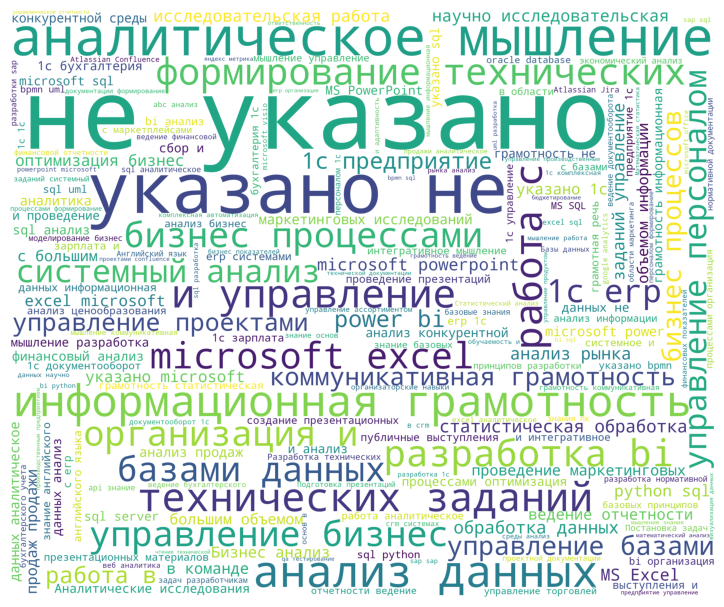

In [45]:
corpus = get_corpus(result['skills'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Можно заметить что самое большое слово - Не указано. Это из-за того что многие работодатели не указывали требуемые навыки. Также одно из больших слов это аналитическое мышление и анализ данных, что довольно логично, т.к. у нас вакансии - аналитик, и это действительно одни из самых важных и ключевых навыков в этой профессии. Остальное рассмотрим в предобработанном виде.

<Axes: >

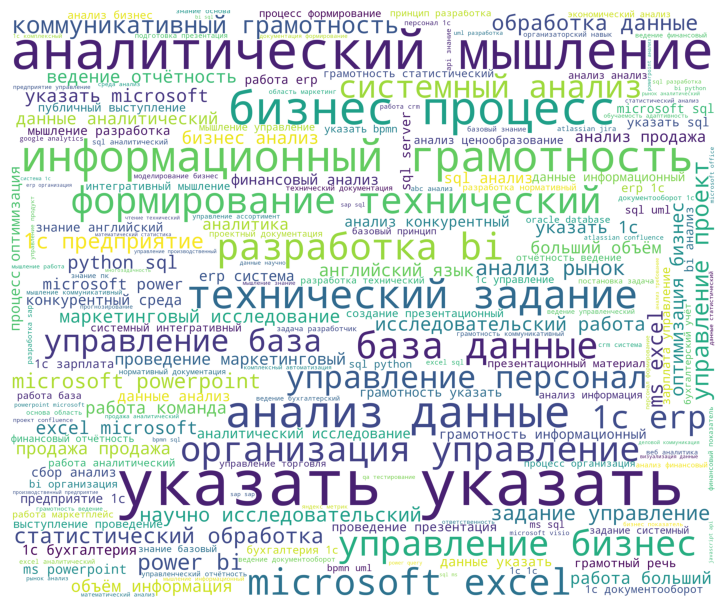

In [46]:
corpus = get_corpus(result['text_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Тут уже список ключевых навыков расширился. Можно заметить что больших слов стало больше, например системный анализ, обработка данных, управление проектов, информационная грамотность, технические задания и т.д. Для большинства BI-аналитиков это действительно важные и ключевые навыки.

Теперь посмотрим отдельно леммитизацию (в виде облака слов) по идексам

In [47]:
# Получение облака слов
def get_wordCloud2(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(corpus)
    return wordCloud

<Axes: >

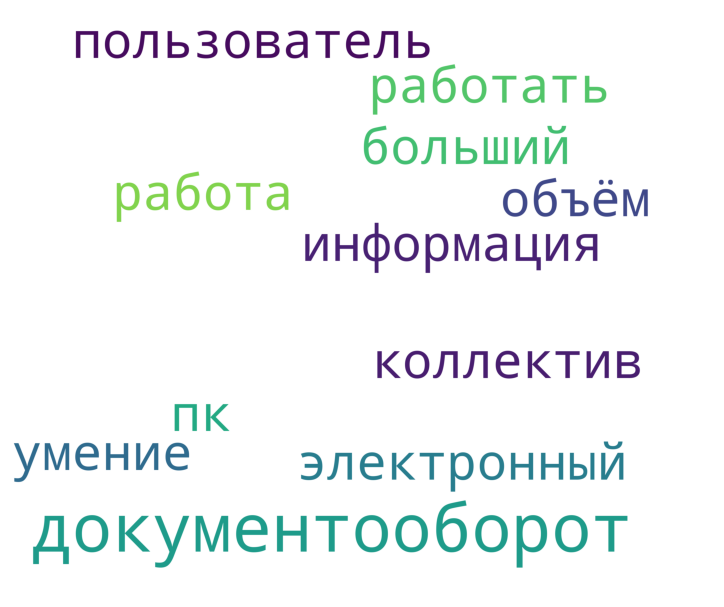

In [48]:
corpus = ' '.join(result['text_lemm'][0])
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Это облако формирует некое представление того что будет требоваться в данной вакансии. Можно предположить что скорее всего эта вакансия как то связана с с работой с документами и какой-то информацией на пк в коллективе.

Давайте посмотрим следующий индекс.

<Axes: >

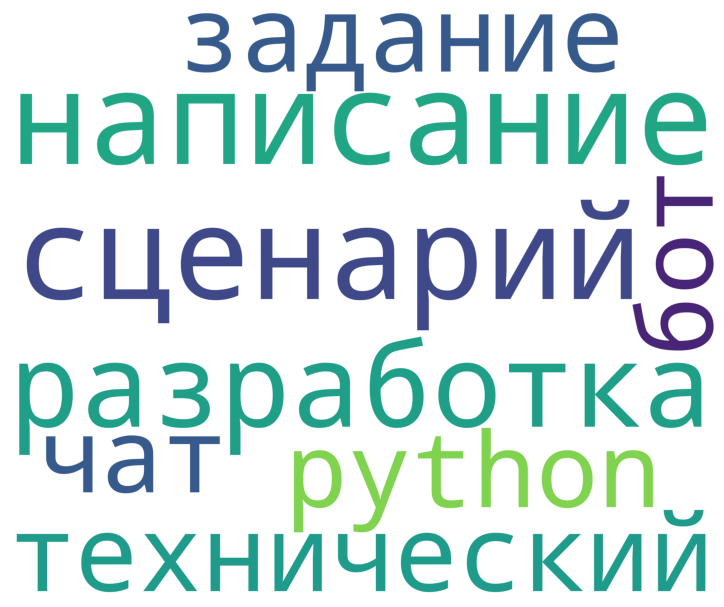

In [49]:
corpus = ' '.join(result['text_lemm'][1])
procWordCloud = get_wordCloud2(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

Тут уже совсем иной случай. Тут уже заметно что профессия связана непосредственно с разработкой чат бота на python.

## 3.1.3. Выявление эмоциональной окраски фраз

Можно так же посмотреть на эмоциональную окраску описания вакансий, посмотрим как чаще всего работодатели любят строить предложения (с каким эмоциональным тоном).

In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer
import ssl

# Настройка NLTK и загрузка необходимых ресурсов.
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

# Инициализация класса для анализа настроения описания
sia = SentimentIntensityAnalyzer()

# Метод анализатор настроений
def analyze_sentiment(text):
    return sia.polarity_scores(text)

# Анализ настроения описания вакансий
data_sentim = result
data_sentim['sentiment'] = data_sentim['description'].dropna().apply(analyze_sentiment)

# Вывод настроения описания вакансий
data_sentim[['description', 'sentiment']].head(10)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,description,sentiment
0,"Обязанности: Расчет, формирование , контроль ...","{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'comp..."
1,Banks Soft Systems - это ведущий разработчик в...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Наша команда расширяется и мы находимся в поис...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,«Спортмастер» — это международный спортивный р...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,"Функции: Разработка SSRS, SSAS отчетности Соз...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
5,PREMIER – это видеосервис с новыми русскими се...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,Ищем Аналитика в Департамент риск-отчётности Ч...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7,GlowByte - лидер в сфере разработки Business I...,"{'neg': 0.0, 'neu': 0.988, 'pos': 0.012, 'comp..."
8,"Российская компания Megaputer Intelligence, од...","{'neg': 0.0, 'neu': 0.986, 'pos': 0.014, 'comp..."
9,В направление импортозамещения ищем Системного...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


В итоге мы получили признак sentiment (настроение), которое показывает четыре основные эмоциональные окраски:
- neg - негативный эмоциональный окрас
- neu - нейтральный эмоциональый окрас
- pos - позитивный эмоциональный окрас
- compound - смешанный (сложносоставляющий) эмоциональый окрас

Чем ближе к 1.0 - тем больше встречается тот или иной эмоциональный окрас.

## 3.1.4. Векторизация текстовых данных

Векторизация текста или преобразование текста в численную форму. Алгоритмы машинного обучения не умеют работать с текстом, поэтому необходимо превратить текст в цифры.

1. Прямое кодирование (one-hot encoding) 

Прямое кодирование (one-hot encoding) считается самым простым способом преобразования токенов в тензоры и выполняется следующим образом:

1. каждый токен представляет бинарный вектор (значения 0 или 1);
2. единица ставится тому элементу, который соответствует номеру токена в словаре.

Проблемой прямого кодирования является размерность. 

2. Bag of words

В отличие от прямого кодирования, мешок слов (Bag of words) выделяет вектору весь документ, и каждый элемент кодируется 1 по порядку следования слов в словаре.


Bag of words решает проблему размерности по одной оси. Количество строк определяется количеством документов. Однако, этот метод не учитывает важность того или иного токена, ведь одно слово может повторятся по несколько раз.

__Мешок слов__ - решает проблему размерности по одной оси. Количество строк определяется количеством документов. Однако, этот метод не учитывает важность того или иного токена, ведь одно слово может повторятся по несколько раз. В пакете scikit-learn есть модуль CountVectorizer, который преобразовывает входной текст в матрицу, значениями которой являются количества вхождения данного ключа(слова) в текст. Таким образом, мы получим матрицу, размерность которой будет равна количеству всех слов, умноженных на количество документов. И элементами матрицы будут числа, которые означают, сколько раз всего слово встретилось в тексте.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
vectorizer = CountVectorizer()
vectorizer.fit(result['text_lemm'])

CountVectorizer()

In [52]:
print(vectorizer.vocabulary_)

{'пользователь': 924, 'пк': 901, 'электронный': 1226, 'документооборот': 617, 'работа': 996, 'больший': 536, 'объём': 860, 'информация': 678, 'умение': 1153, 'работать': 997, 'коллектив': 706, 'написание': 825, 'сценарий': 1108, 'разработка': 1004, 'технический': 1125, 'задание': 629, 'python': 346, 'чат': 1210, 'бот': 537, 'указать': 1151, 'ms': 280, 'visio': 451, 'business': 80, 'studio': 405, 'powerpoint': 335, 'оптимизация': 868, 'бизнес': 529, 'процесс': 989, 'sql': 398, 'ssis': 401, 'server': 383, 'ssas': 400, 'ssrs': 402, 'powerbi': 333, 'etl': 155, 'postgresql': 330, 'tableau': 416, 'power': 332, 'bi': 66, 'clickhouse': 100, 'datastudio': 120, 'анализ': 498, 'поведение': 911, 'аналитика': 501, 'данные': 591, 'риск': 1027, 'intelligence': 206, 'linux': 240, 'xml': 467, 'json': 223, 'xsd': 469, 'schema': 374, 'rest': 364, 'web': 457, 'uml': 438, 'select': 378, 'join': 221, 'update': 441, 'insert': 205, 'case': 86, 'soap': 388, 'kafka': 226, 'elt': 146, 'аналитический': 502, 'мышл

Можно увидеть что мы получили словарь с самим словом и кол-вом этого слова

In [53]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)
count_matrix = vectorizer.fit_transform(result['text_lemm'])

In [54]:
count_matrix.shape

(7404, 13966)

In [55]:
vectorizer.get_feature_names_out()[1000:1500]

array(['bpmn uml idef0', 'bpmn uml itil', 'bpmn uml rest',
       'bpmn uml soap', 'bpmn uml sql', 'bpmn uml use', 'bpmn uml user',
       'bpmn uml автоматизация', 'bpmn uml аналитический',
       'bpmn uml моделирование', 'bpmn uml организация',
       'bpmn uml разработка', 'bpmn uml системный', 'bpmn uml субд',
       'bpmn uml формирование', 'bpmn uml чтз', 'bpmn use',
       'bpmn use case', 'bpmn xml', 'bpmn xml uml', 'bpmn анализ',
       'bpmn анализ данные', 'bpmn анализ продажа', 'bpmn аналитика',
       'bpmn аналитика xml', 'bpmn аналитический',
       'bpmn аналитический мышление', 'bpmn бизнес', 'bpmn бизнес анализ',
       'bpmn ведение', 'bpmn ведение документооборот',
       'bpmn моделирование', 'bpmn моделирование бизнес',
       'bpmn оптимизация', 'bpmn оптимизация бизнес', 'bpmn организация',
       'bpmn организация управление', 'bpmn постановка',
       'bpmn постановка задача', 'bpmn применение',
       'bpmn применение методология', 'bpmn работа', 'bpmn работ

Получили массив значимых (feature) слов.

Давайте выведем количественную матрицу и посмотрим что получилось

In [56]:
print(count_matrix)

  (0, 10456)	1
  (0, 10139)	1
  (0, 13839)	1
  (0, 7146)	2
  (0, 11386)	1
  (0, 6101)	1
  (0, 9686)	1
  (0, 7687)	1
  (0, 13111)	1
  (0, 11542)	1
  (0, 8091)	1
  (0, 10467)	1
  (0, 10171)	1
  (0, 13842)	1
  (0, 7182)	1
  (0, 11431)	1
  (0, 6106)	1
  (0, 9687)	1
  (0, 7755)	1
  (0, 7190)	1
  (0, 13125)	1
  (0, 11543)	1
  (0, 10472)	1
  (0, 10172)	1
  (0, 13844)	1
  :	:
  (7403, 2421)	1
  (7403, 1659)	1
  (7403, 2495)	1
  (7403, 2423)	1
  (7403, 1668)	1
  (7403, 1567)	1
  (7403, 63)	1
  (7403, 1568)	1
  (7403, 11326)	1
  (7403, 8026)	1
  (7403, 9303)	1
  (7403, 712)	1
  (7403, 11609)	1
  (7403, 9291)	1
  (7403, 5615)	1
  (7403, 9292)	1
  (7403, 6845)	1
  (7403, 6846)	1
  (7403, 4524)	1
  (7403, 2505)	1
  (7403, 4525)	1
  (7403, 10774)	1
  (7403, 713)	1
  (7403, 11338)	1
  (7403, 9304)	1


3. TF-IDF

TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency) — статистическая мера, используемая для оценки важности слова в контексте документа, являющегося частью коллекции документов или корпуса. Вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции.

TF-IDF состоит из двух компонентов: Term Frequency (частотность слова в документе) и Inverse Document Frequency (инверсия частоты документа). Они считаются следующим образом:

__TF-IDF__ - это способ векторизации текста, отражающий важность слова в документе, а не только частоту его появления. В тексте большого объема некоторые слова могут присутствовать очень часто, но при этом не нести никакой значимой информации о фактическом содержании текста (документа). Если такие данные передавать непосредственно классификатору, то такие частые термины могут затенять частоты более редких, но при этом более интересных терминов. Для того, чтобы этого избежать, достаточно разделить количество употреблений каждого слова в документе на общее количество слов в документе, это есть TF — частота термина. Термин IDF (inverse document frequency) обозначает обратную частоту термина (инверсия частоты) с которой некоторое слово встречается в документах. IDF позволяет измерить непосредственную важность термина.


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=russian_stopwords,
                                 ngram_range=(1,3))

In [35]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(result['text_lemm'])

CPU times: total: 219 ms
Wall time: 278 ms


In [36]:
tfidf_matrix.shape

(7404, 295)

В итоге мы получили матрицу TF-IDF, посмотрим какие тут получились значисые слова.

In [65]:
tfidf_vectorizer.get_feature_names_out()[:100]

array(['1с', '1с 1с', '1с erp', '1с erp 1с', '1с бухгалтерия',
       '1с бухгалтерия 1с', '1с документооборот', '1с зарплата',
       '1с зарплата управление', '1с предприятие', '1с предприятие 1с',
       '1с управление', '1с управление торговля', 'analysis', 'analytics',
       'api', 'atlassian', 'atlassian jira', 'bi', 'bi анализ',
       'bi анализ данные', 'bi организация', 'bi организация управление',
       'bpmn', 'bpmn uml', 'confluence', 'crm', 'erp', 'erp 1с',
       'erp система', 'excel', 'excel microsoft',
       'excel microsoft powerpoint', 'excel анализ', 'google',
       'javascript', 'jira', 'microsoft', 'microsoft excel',
       'microsoft excel microsoft', 'microsoft power',
       'microsoft power bi', 'microsoft powerpoint', 'microsoft sql',
       'microsoft sql server', 'ms', 'ms excel', 'ms powerpoint',
       'ms sql', 'office', 'oracle', 'postgresql', 'power', 'power bi',
       'powerpoint', 'python', 'python sql', 'rest', 'sap', 'server',
       'sql', '

In [66]:
print(tfidf_matrix)

  (0, 107)	0.26772236752950795
  (0, 237)	0.26772236752950795
  (0, 186)	0.26772236752950795
  (0, 106)	0.26772236752950795
  (0, 236)	0.26772236752950795
  (0, 152)	0.2516366199837409
  (0, 185)	0.26772236752950795
  (0, 105)	0.26716413799129085
  (0, 229)	0.17709168931470468
  (0, 131)	0.5503793187347493
  (0, 195)	0.3177607236359404
  (1, 247)	0.4949771211864818
  (1, 269)	0.3312008327544372
  (1, 246)	0.4918947397733321
  (1, 55)	0.33137352329776437
  (1, 132)	0.3312008327544372
  (1, 267)	0.3223314172237903
  (1, 239)	0.28274242125746235
  (2, 273)	1.0
  (3, 189)	0.3018942379209627
  (3, 101)	0.24740735621032334
  (3, 188)	0.3018942379209627
  (3, 47)	0.32844986155318856
  (3, 219)	0.24494521675449527
  (3, 99)	0.22280731911678656
  :	:
  (7403, 257)	0.08175931461290904
  (7403, 146)	0.08175931461290904
  (7403, 37)	0.09647303358346437
  (7403, 278)	0.3170646460965833
  (7403, 277)	0.3170646460965833
  (7403, 2)	0.06584894677341109
  (7403, 190)	0.31408262546694615
  (7403, 27)	0.

По этой матрице что-то сказать сложно, но в будущем она нам пригодится для нахождения частоты (важности) навыков.

# 3.2. Тематическое моделирование

Тематическое моделирование позволяет выделять из текстов темы, связанные с определенными множествами слов, и затем смотреть, с какой вероятностью тексты соотносятся с этими темами. 

Библиотека **gensim**. Это популярная открытая библиотека для тематического моделирования, в которой есть нужная модель — LDA (Латентном размещении Дирихле (LDA)). Затем следует создать словарь для тематического моделирования из лемматизированного текста. 

После создания словаря лучше всего отфильтровать те слова, которые встречаются в слишком большом количестве текстов, и те, которые встречаются слишком редко. Для этого есть метод filter_extremes, который принимает в себя аргументы no_above (только слова, которые встречаются не более чем в указанной доле текстов) и no_below (слова, которые встречаются не менее чем в указанном количестве текстов). 

После удаления лишних слов словарь лучше всего ужать в размерах, убрав пропуски с помощью метода compactify.

In [68]:
import gensim

In [69]:
def tokenize2(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens

In [70]:
result['text_lemm3'] = [tokenize2(text) for text in result['text_lemm']]

In [71]:
gensim_dictionary = gensim.corpora.Dictionary(result['text_lemm3'])
gensim_dictionary.filter_extremes(no_above=0.1, no_below=20)
gensim_dictionary.compactify()

In [72]:
corpus = [gensim_dictionary.doc2bow(text) 
          for text in result['text_lemm3']]

In [73]:
lda_20 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=20, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

Посмотрим какие топики получились

In [74]:
lda_20.print_topics()

[(0,
  '0.270*"sap" + 0.178*"oracle" + 0.151*"database" + 0.121*"база" + 0.063*"erp-система" + 0.052*"postgresql" + 0.023*"информационный" + 0.020*"обучение" + 0.020*"java/kotlin/scala" + 0.016*"crm-система"'),
 (1,
  '0.163*"маркетинговый" + 0.140*"исследование" + 0.121*"проведение" + 0.104*"рынок" + 0.077*"конкурентный" + 0.075*"среда" + 0.039*"информационный" + 0.039*"научно-исследовательский" + 0.038*"стратегия" + 0.027*"ценообразование"'),
 (2,
  '0.202*"технический" + 0.177*"задание" + 0.167*"формирование" + 0.073*"персонал" + 0.062*"документация" + 0.041*"системный" + 0.030*"чтение" + 0.026*"проектный" + 0.025*"тестирование" + 0.024*"qa"'),
 (3,
  '0.191*"информационный" + 0.149*"ведение" + 0.120*"отчётность" + 0.095*"коммуникативный" + 0.039*"команда" + 0.033*"powerpoint" + 0.032*"финансовый" + 0.032*"грамотный" + 0.032*"речь" + 0.027*"документооборот"'),
 (4,
  '0.296*"проект" + 0.086*"продукт" + 0.060*"confluence" + 0.046*"bpmn" + 0.042*"задача" + 0.040*"постановка" + 0.039*"

LDA - это метод машинного обучения, который используется для анализа тематической структуры в больших наборах документов. Который использует модель вероятности, чтобы определить, какие темы присутствуют в каждом документе, и какие слова связаны с каждой темой. LDA может быть полезен в случаях, когда нужно опредлить тематическую структуру в большом наборе документов, таких как статьи и т.д. 

In [79]:
from sklearn.decomposition import LatentDirichletAllocation

In [80]:
# Cоздание модели LDA
lda_model = LatentDirichletAllocation(n_components=6, random_state=0)
lda_model.fit(count_matrix)

# Вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: анализ, данные, microsoft, грамотность, аналитический, мышление, информационный грамотность, информационный, аналитический мышление, работа
Topic 1: sql, анализ, api, данные, управление, bpmn, python, sap, uml, системный
Topic 2: 1с, erp, управление, 1с erp, предприятие, 1с предприятие, персонал, управление персонал, технический, технический задание
Topic 3: управление, бизнес, процесс, бизнес процесс, разработка, технический, задание, технический задание, организация, управление бизнес процесс
Topic 4: указать, ведение, отчётность, microsoft, финансовый, учёт, отчётность ведение, управленческий, работа, ведение отчётность
Topic 5: анализ, ms, бизнес, аналитический, информация, sql, финансовый, ms excel, excel, аналитика


В итоге у нас получилось 6 топиков (мы указали) и модель распределила слова так. В принципе можно представить за что отвечает каждый топик (какая профессия и т.д. но лучше посмотреть более подробные топики дальше)

NMF - это метод машинного обучения, который используется для разложения матрицы на две с неотрицательными элементами. Он может быть полезен в случаях, когда нужно найти скрытые признаки в данных, таких как тексты и т.д. NMF может использоваться в различных областях, таких как обработка изображений, текстовый анализ и т.д

In [81]:
from sklearn.decomposition import NMF

In [82]:
# Создание модели NMF
nmf_model = NMF(n_components=10, random_state=0)
nmf_model.fit(tfidf_matrix)

# Вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: указать, маркетинговый, проведение, маркетинговый исследование, проведение маркетинговый исследование, проведение маркетинговый, исследование, научно исследовательский работа, научно исследовательский, научно
Topic 1: анализ, ms, аналитический, информация, мышление, аналитический мышление, ms excel, работа, аналитика, финансовый
Topic 2: технический, задание, технический задание, формирование технический задание, формирование технический, формирование, управление, технический задание управление, задание управление, персонал
Topic 3: sql, python, python sql, sql python, bi, математический, power, power bi, аналитика, postgresql
Topic 4: microsoft, microsoft excel, excel, excel microsoft, microsoft excel microsoft, microsoft powerpoint, powerpoint, power, excel microsoft powerpoint, bi
Topic 5: 1с, erp, 1с erp, предприятие, 1с предприятие, управление, 1с erp 1с, erp 1с, бухгалтерия, 1с бухгалтерия
Topic 6: бизнес, процесс, бизнес процесс, управление бизнес, управление бизнес про

Тут уже заметно более точное распределение слов. Можно заметить что слова группируются по смыслу и по английским словам. Например седьмой топик явно указывает на работу с microsoft продукцией.

LSA - это метод машинного обучения, который используется для анализа структуры в больших наборах текстовых данных. Он использует матричные вычисления для определения близости между словами и документами. LSA может быть полезен в случаях, когда вы хотите определить структуру в большом наборе текстовых данных, таких как статьи, отчеты и т.д.

In [83]:
from sklearn.decomposition import TruncatedSVD

In [84]:
# Создание модели LSA
lsa_model = TruncatedSVD(n_components=6, random_state=0)
lsa_model.fit(tfidf_matrix)

# Вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: указать, управление, финансовый, проект, управление проект, английский, язык, английский язык, sql, финансовый анализ
Topic 1: анализ, sql, данные, управление, microsoft, аналитический, мышление, аналитический мышление, грамотность, анализ данные
Topic 2: 1с, управление, процесс, бизнес процесс, бизнес, erp, технический, задание, технический задание, формирование технический задание
Topic 3: sql, python, python sql, bpmn, api, uml, системный, системный анализ, sql python, бизнес
Topic 4: sql, microsoft, 1с, python, microsoft excel, python sql, erp, excel, 1с erp, грамотность
Topic 5: 1с, ms, erp, 1с erp, ms excel, анализ, информация, предприятие, аналитика, 1с предприятие


LSA модель тоже неплохо справилась, но для большей точности лучше полагаться на модель NMF

## 3.3. Кластеризация

In [58]:
pip install threadpoolctl==3.1.0

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
Note: you may need to restart the kernel to use updated packages.


Возьмем кол-во кластеров 5. Когда мы рассматривали топики, мы нашли несколько схожих по тематике группы навыков. (языки, 1с, питон, microsoft, не указано) и т.д.

In [37]:
num_clusters = 5

# Метод к-средних - KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters)

In [38]:
%%time
km.fit(tfidf_matrix)

CPU times: total: 672 ms
Wall time: 1.26 s


KMeans(n_clusters=5)

In [39]:
%%time
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: total: 469 ms
Wall time: 263 ms


In [40]:
len(km.labels_)
clusters[:20]

[0, 2, 1, 2, 3, 3, 3, 3, 1, 0, 2, 3, 1, 2, 2, 1, 2, 0, 1, 0]

In [41]:
clusterkm = km.labels_.tolist()
frame = pd.DataFrame()

# Метод к-средних - KMeans
out = { 'text': result['skills'], 'cluster': clusterkm }
frame1 = pd.DataFrame(out, columns = ['text', 'cluster'])

In [42]:
frame1

,text,cluster
0,Пользователь ПК; Электронный документооборот; ...,0
1,Написание сценариев; Разработка технических за...,2
2,Не указано,1
3,MS Visio; Business Studio; MS PowerPoint; Опти...,2
4,Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,3
...,...,...
6197,не указано,1
6198,не указано,1
6199,не указано,1
6200,анализ конкурентной среды;аналитическое мышлен...,0


In [43]:
frame1[frame1['cluster']==0]

,text,cluster
0,Пользователь ПК; Электронный документооборот; ...,0
9,Linux,0
17,Аналитический склад ума; Системное мышление; В...,0
19,Ведение отчетности; Пользователь ПК; Анализ да...,0
24,MS Excel; ВЭД; SAP; Управление товарными запас...,0
...,...,...
6180,работа с диаграммами;microsoft excel;microsoft...,0
6184,1с: предприятие;microsoft excel;microsoft powe...,0
6186,microsoft powerpoint;microsoft project;информа...,0
6188,управление ассортиментом;аналитическое мышлени...,0


In [44]:
frame1[frame1['cluster']==1]

,text,cluster
2,Не указано,1
8,Не указано,1
12,Не указано,1
15,Не указано,1
18,Не указано,1
...,...,...
6195,не указано,1
6196,не указано,1
6197,не указано,1
6198,не указано,1


In [45]:
frame1[frame1['cluster']==2]

,text,cluster
1,Написание сценариев; Разработка технических за...,2
3,MS Visio; Business Studio; MS PowerPoint; Опти...,2
10,"XML/JSON, XSD/JSON Schema; REST/Web; UML; SQL;...",2
13,Бизнес-анализ; Работа с большим объемом информ...,2
14,BPMN; EPC; UML; AS IS/TO BE mapping; Бизнес-ан...,2
...,...,...
6175,bpmn;управление проектами;научно-исследователь...,2
6176,1с: документооборот;bpmn;microsoft visio;разра...,2
6182,организация и управление бизнес-процессами;фор...,2
6192,битрикс;amocrm;битрикс;работа в crm-системах;а...,2


In [46]:
frame1[frame1['cluster']==3]

,text,cluster
4,Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,3
5,SQL; Tableau; PowerBI; Power BI; ClickHouse; D...,3
6,SQL; аналитика данных; Анализ рисков,3
7,SQL; Business intelligence; BI,3
11,SQL; аналитика,3
...,...,...
6165,microsoft excel;sql;разработка bi,3
6168,microsoft excel;oracle database;microsoft powe...,3
6169,microsoft excel;microsoft power bi;sql;анализ ...,3
6171,анализ данных;dwh;hadoop;microsoft sql server;...,3


In [47]:
frame1[frame1['cluster']==4]

,text,cluster
78,1С: Предприятие; Анализ продаж; Управление тов...,4
159,ERP и учетные системы; IT; ERP Systems; ERP; SQL,4
178,1С: БГУ; Бухгалтерский учёт; Бизнес-процессы; ...,4
195,"1С Анализ; Проектная документация; Учет, финан...",4
274,MS Visio; BPMN; UML; Автоматизация процессов; ...,4
...,...,...
6153,1с: зарплата и управление персоналом;1с;1с: за...,4
6154,1с: зарплата и управление персоналом;1с: компл...,4
6155,1с: зарплата и управление персоналом;1с: компл...,4
6174,1с: зарплата и управление персоналом;ведение к...,4


In [48]:
frame1['cluster'].value_counts()

cluster
1    3057
0    1988
2    1022
3     841
4     496
Name: count, dtype: int64

В итоге у нас получилось пять групп навыков:
1. Навыки которые тесно связаны с разработкой и управлением различных систем (кластер 0)
2. Навыки которые не указали работодатели (кластер 1)
3. Навыки которые связаны с работой с базами данных SQL (кластер 2)
4. Навыки которые связаны с 1C разработкой (кластер 3)
5. Навыки которые тесно связаны с bpmn и организацией и управлением биз (кластер 4)

Так же можно поиграться с кол-вом кластеров и посмотреть как модель распределит навыки, но пока что будет достаточно и этого.

## 3.4. Классификация

Теперь на основе наших кластеров можно сделать классификацию, для опеределения класса навыков.

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(result['skills'], frame1['cluster'], test_size=0.2, random_state=42)

# Преобразование текстовых данных
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Обучение модели
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Оценка модели
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

# Предсказание
new_data = ['1С 1C', 'Не указан', 'SQL MS SQL Server']
new_data_tfidf = vectorizer.transform(new_data)
predictions = model.predict(new_data_tfidf)
print("Предсказания:", predictions)


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       402
           1       1.00      1.00      1.00       601
           2       0.99      0.95      0.97       216
           3       0.94      0.93      0.94       168
           4       0.99      0.99      0.99        94

    accuracy                           0.98      1481
   macro avg       0.97      0.97      0.97      1481
weighted avg       0.98      0.98      0.98      1481

Предсказания: [4 1 3]


Модель отработала хорошо. Показатели точности очень высокие. На новом датафрейме отработала хорошо, всё предсказала верно: третий кластер связан с 1С, первый кластер не указан, второй кластер связан с разработкой и ЯП. Модель всё предсказала верно.

## 3.5. Таблица с классами навыков, содержанием и частотой встречаемости

Теперь благодаря модели на основе классификации, можно построить требуемую таблицу с классами навыков, содержанием и частотой встречаемости.

In [50]:
# Извлечение и очистка данных навыков
skills_series = result['skills'].dropna().str.lower().str.split(';').explode().str.strip()
skills_count = skills_series.value_counts()

# Создание датафрейма для таблицы частоты навыков.
skills_freq_table = pd.DataFrame({
    'Skill': skills_count.index,
    'Frequency': skills_count.values
})

skills_freq_table.head(10)

,Skill,Frequency
0,не указано,3057
1,sql,1342
2,аналитическое мышление,1269
3,анализ данных,845
4,информационная грамотность,813
5,bpmn,588
6,разработка bi,585
7,формирование технических заданий,580
8,microsoft excel,560
9,python,550


In [51]:
skills_freq_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Skill      1401 non-null   object
 1   Frequency  1401 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.0+ KB


Всего у нас получилось 1401 уникальных навыков, теперь определим для каждого из них свой класс навыков (зададим им кластер через классификацию)

In [52]:
# Предсказание
Classification_skills = skills_freq_table['Skill']
Classification_tfidf = vectorizer.transform(Classification_skills)
Classification = model.predict(Classification_tfidf)

In [53]:
skills_freq_table['Classification'] = Classification

In [54]:
skills_freq_table.head(10)

,Skill,Frequency,Classification
0,не указано,3057,1
1,sql,1342,3
2,аналитическое мышление,1269,0
3,анализ данных,845,0
4,информационная грамотность,813,0
5,bpmn,588,2
6,разработка bi,585,2
7,формирование технических заданий,580,2
8,microsoft excel,560,0
9,python,550,3


In [55]:
skills_freq_table[skills_freq_table['Classification']==4]

,Skill,Frequency,Classification
11,1с: erp,438,4
30,1с: предприятие,213,4
39,1с: бухгалтерия,156,4
43,работа с erp-системами,138,4
44,1с: зарплата и управление персоналом,135,4
50,1с: документооборот,115,4
51,1с,109,4
57,1с: управление торговлей,94,4
94,разработка 1с,61,4
95,1с: комплексная автоматизация,60,4


В итоге у нас получилась таблица с классами навыков,содержанием и частотой встречаемости навыков. В дальнейшем её можно будет использовать для построения графов (сетевой анализ).

## 3.6. Проведение анализа полученных классов навыков

In [56]:
result.count()

id               7404
company          7404
name             7404
description      7404
skills           7404
date_public      7404
schedule         7404
region           7404
experience       7404
salary           7404
prep_text        7404
tokenize_text    7404
text_stem        7404
text_lemm        7404
sentiment        7404
dtype: int64

In [57]:
frame1.count()

text       7404
cluster    7404
dtype: int64

In [58]:
result['cluster'] = frame1['cluster']

In [59]:
result.head()

,id,company,name,description,skills,date_public,schedule,region,experience,salary,prep_text,tokenize_text,text_stem,text_lemm,sentiment,cluster
0,73013752,Не указано,Аналитик в планово-диспетчерский отдел,"Обязанности: Расчет, формирование , контроль ...",Пользователь ПК; Электронный документооборот; ...,2024-04-05T08:55:42+0300,Полный день,Москва,От 1 года до 3 лет,116000.0,пользователь пк электронный документооборот ра...,Пользователь ПК ; Электронный документооборот ...,пользовател пк ; электрон документооборот ; ра...,пользователь пк ; электронный документооборот ...,"{'neg': 0.0, 'neu': 0.943, 'pos': 0.057, 'comp...",0
1,76533535,Не указано,Аналитик в команду внедрения ботов,Banks Soft Systems - это ведущий разработчик в...,Написание сценариев; Разработка технических за...,2024-03-25T11:07:32+0300,Удаленная работа,Москва,От 1 года до 3 лет,0.0,написание сценариев разработка технических зад...,Написание сценариев ; Разработка технических з...,написан сценар ; разработк техническ задан ; P...,написание сценарий ; разработка технический за...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2
2,77195081,Не указано,Системный аналитик в IT Компанию РОЛЬФТЕХ (уда...,Наша команда расширяется и мы находимся в поис...,Не указано,2024-04-17T09:34:24+0300,Полный день,Москва,От 1 года до 3 лет,0.0,не указано,Не указано,не указа,указать,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",1
3,77538397,"Компания «СПОРТМАСТЕР», Офис",Бизнес-аналитик,«Спортмастер» — это международный спортивный р...,MS Visio; Business Studio; MS PowerPoint; Опти...,2024-03-27T09:32:37+0300,Полный день,Москва,От 1 года до 3 лет,0.0,ms visio business studio ms powerpoint оптимиз...,MS Visio ; Business Studio ; MS PowerPoint ; О...,MS Visio ; Business Studio ; MS PowerPoint ; о...,ms visio ; business studio ; ms powerpoint ; о...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",2
4,81311010,ДИКСИ. IT,Разработчик-аналитик SQL (Junior),"Функции: Разработка SSRS, SSAS отчетности Соз...",Python; SQL; SSIS; MS SQL Server; C#; SSAS; SS...,2024-03-22T12:42:39+0300,Удаленная работа,Москва,От 3 до 6 лет,0.0,python sql ssis ms sql server c ssas ssrs powe...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,Python ; SQL ; SSIS ; MS SQL Server ; C # ; SS...,python ; sql ; ssis ; ms sql server ; c # ; ss...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",3


In [62]:
result[result['cluster']==4]

,id,company,name,description,skills,date_public,schedule,region,experience,salary,prep_text,tokenize_text,text_stem,text_lemm,sentiment,cluster
78,92062721,Не указано,Начинающий специалист в аналитике,Начинающий специалист в аналитике со знанием E...,1С: Предприятие; Анализ продаж; Управление тов...,2024-04-15T14:34:01+0300,Полный день,Москва,Нет опыта,65000.0,с предприятие анализ продаж управление товарн...,1С : Предприятие ; Анализ продаж ; Управление ...,1с : предприят ; анализ продаж ; управлен това...,1с : предприятие ; анализ продажа ; управление...,"{'neg': 0.0, 'neu': 0.955, 'pos': 0.045, 'comp...",4
159,93669077,Ozon Информационные технологии,"Старший системный аналитик, ERP и учетные системы",Мы обеспечиваем весь спектр работ связанных с ...,ERP и учетные системы; IT; ERP Systems; ERP; SQL,2024-03-23T14:15:19+0300,Полный день,Москва,От 3 до 6 лет,0.0,erp и учетные системы it erp systems erp sql,ERP учетные системы ; IT ; ERP Systems ; ERP ;...,ERP учетн систем ; IT ; ERP Systems ; ERP ; SQL,erp учётный система ; it ; erp systems ; erp ;...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4
178,93930800,Не указано,Аналитик-консультант 1С: БГУ,В Центр Цифровых Технологий МГТУ им. Н.Э. Баум...,1С: БГУ; Бухгалтерский учёт; Бизнес-процессы; ...,2024-03-29T11:48:32+0300,Полный день,Москва,От 1 года до 3 лет,150000.0,с бгу бухгалтерский учёт бизнес процессы анал...,1С : БГУ ; Бухгалтерский учёт ; Бизнес-процесс...,1с : бгу ; бухгалтерск учет ; бизнес-процесс ;...,1с : бгу ; бухгалтерский учёт ; бизнес-процесс...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4
195,94121775,Не указано,"Аналитик 1С: ERP (блоки: казначейство, продажи...",TNext реализует полный спектр услуг по внедрен...,"1С Анализ; Проектная документация; Учет, финан...",2024-03-31T18:14:23+0300,Полный день,Москва,От 3 до 6 лет,180000.0,с анализ проектная документация учет финансы ...,"1С Анализ ; Проектная документация ; Учет , фи...","1с анализ ; проектн документац ; учет , финанс...","1с анализ ; проектный документация ; учёт , фи...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4
274,94960804,Не указано,Системный аналитик 1С,Центр Внедрения Профальянс - аккредитованная И...,MS Visio; BPMN; UML; Автоматизация процессов; ...,2024-03-29T19:44:20+0300,Удаленная работа,Москва,От 1 года до 3 лет,0.0,ms visio bpmn uml автоматизация процессов с пр...,MS Visio ; BPMN ; UML ; Автоматизация процессо...,MS Visio ; BPMN ; UML ; автоматизац процесс ; ...,ms visio ; bpmn ; uml ; автоматизация процесс ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6153,94465594,ibs,консультант 1с:зуп,дивизион бизнес-решений внедряет комплексные р...,1с: зарплата и управление персоналом;1с;1с: за...,2024-03-10 00:00:00,удаленная работа,свердловская область,от 1 года до 3 лет,0.0,с зарплата и управление персоналом с с зарпла...,1с : зарплата управление персоналом ; 1с ; 1с ...,1с : зарплат управлен персонал ; 1с ; 1с : зар...,1с : зарплата управление персонал ; 1с ; 1с : ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4
6154,94472153,рбк,аналитик по внедрению 1с,о компании «рбк» идеи и идеалы: холдинг рбк — ...,1с: зарплата и управление персоналом;1с: компл...,2024-03-10 00:00:00,удаленная работа,москва,от 1 года до 3 лет,200000.0,с зарплата и управление персоналом с комплекс...,1с : зарплата управление персоналом ; 1с : ком...,1с : зарплат управлен персонал ; 1с : комплекс...,1с : зарплата управление персонал ; 1с : компл...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",4
6155,94472154,рбк,аналитик по внедрению 1с,о компании «рбк» идеи и идеалы: холдинг рбк — ...,1с: зарплата и управление персоналом;1с: компл...,2024-03-10 00:00:00,удаленная работа,санкт-петербург,от 1 года до 3 лет,200000.0,с зарплата и управление персоналом с комплекс...,1с : зарплата управление персоналом ; 1с : ком...,1с : зарплат управлен персонал ; 1с : комплекс...,1с : зарплата управление персонал ; 1с : компл

In [60]:
# Сохраняем таблицу с частотой, содержанием и классом навыков в файл Excel с учетом кодировки
result.to_excel('data_clustered.xlsx', index=False)

In [61]:
# Сохраняем таблицу с частотой, содержанием и классом навыков в файл Excel с учетом кодировки
skills_freq_table.to_excel('data_skills.xlsx', index=False)

In [ ]:
result

In [113]:
# Подсчет количества вакансий в каждом регионе для каждого кластера навыков
region_skills_demand = result.groupby(['region', 'cluster']).size().reset_index(name='counts')
region_skills_demand.head

<bound method NDFrame.head of                    region  cluster  counts
0                  Москва        0     337
1                  Москва        1     457
2                  Москва        2     204
3                  Москва        3      26
4                  Москва        4     178
5     воронежская область        0      33
6     воронежская область        1      30
7     воронежская область        2       7
8     воронежская область        3      10
9     воронежская область        4      10
10     краснодарский край        0      46
11     краснодарский край        1      43
12     краснодарский край        2      10
13     краснодарский край        3      14
14     краснодарский край        4      19
15                 москва        0    1103
16                 москва        1    1906
17                 москва        2     549
18                 москва        3     268
19                 москва        4     585
20  нижегородская область        0      64
21  нижегородская област

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

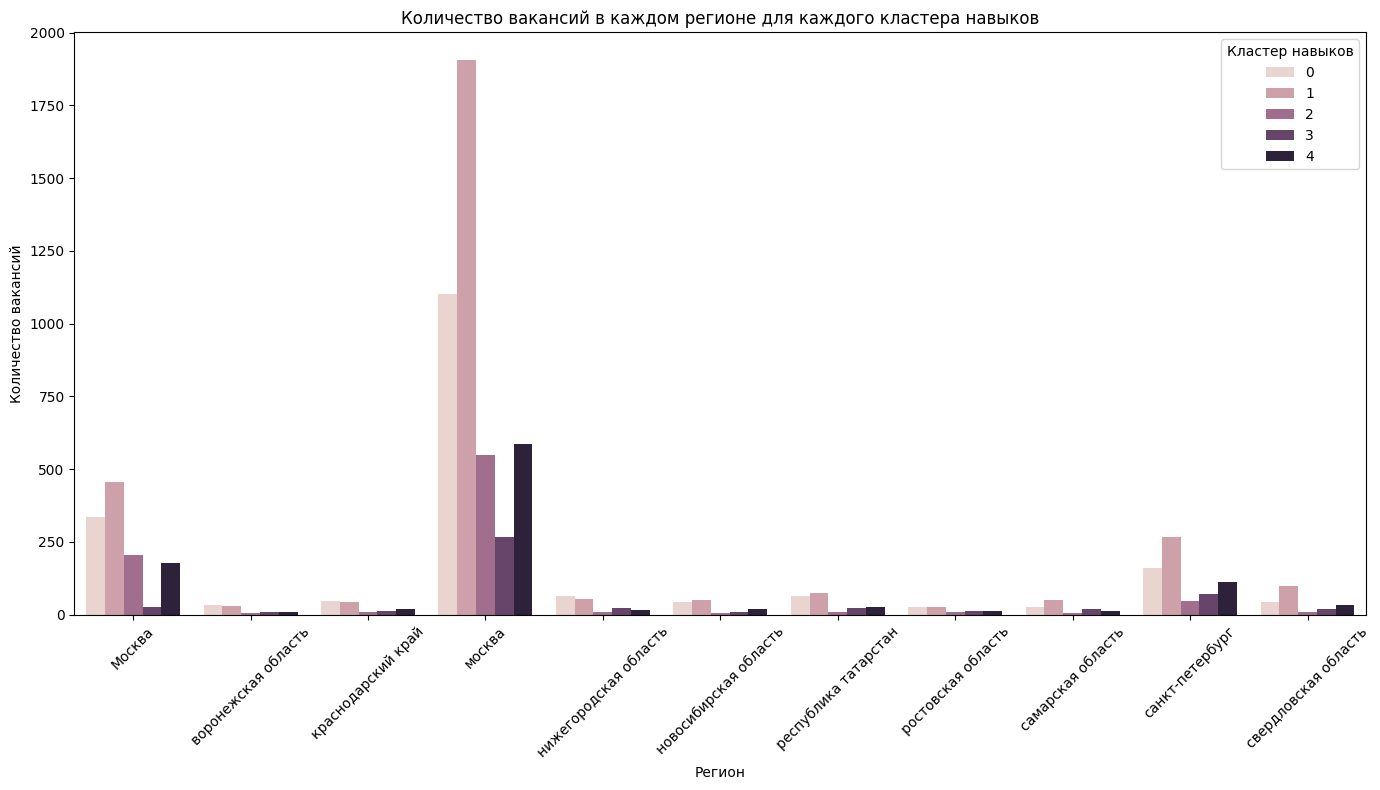

In [116]:
# Визуализация данных
plt.figure(figsize=(14, 8))
sns.barplot(data=region_skills_demand, x='region', y='counts', hue='cluster')
plt.title('Количество вакансий в каждом регионе для каждого кластера навыков')
plt.xlabel('Регион')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.legend(title='Кластер навыков')
plt.tight_layout()
plt.show()

In [117]:
# Подсчет количества вакансий в каждом регионе для каждого кластера навыков
region_skills_demand = result.groupby(['region', 'cluster']).size().reset_index(name='counts')

# Вычисление доли вакансий в каждом регионе для каждого кластера навыков
region_skills_demand['share'] = region_skills_demand['counts'] / region_skills_demand.groupby('region')['counts'].transform('sum')

# Сортировка по убыванию доли вакансий
region_skills_demand_sorted = region_skills_demand.sort_values(['region', 'share'], ascending=[True, False])

# Вывод наиболее востребованных навыков в каждом регионе
print("Региональная специфика востребованных навыков:")
print(region_skills_demand_sorted.groupby('region').head(1))

Региональная специфика востребованных навыков:
                   region  cluster  counts     share
1                  Москва        1     457  0.380200
5     воронежская область        0      33  0.366667
10     краснодарский край        0      46  0.348485
16                 москва        1    1906  0.432102
20  нижегородская область        0      64  0.385542
26  новосибирская область        1      52  0.385185
31   республика татарстан        1      74  0.381443
35     ростовская область        0      27  0.306818
41      самарская область        1      51  0.432203
46        санкт-петербург        1     266  0.403030
51   свердловская область        1      99  0.475962


Выше можно убедиться в этих данных на графике.

In [120]:
# Удаление строк с пропущенными значениями в столбце "salary"
df_clean = result.dropna(subset=['salary'])

# Вычисление средней заработной платы для каждого кластера навыков
avg_salary_by_skills = df_clean.groupby('cluster')['salary'].mean().reset_index(name='avg_salary')

# Сортировка по убыванию средней заработной платы
avg_salary_by_skills_sorted = avg_salary_by_skills.sort_values('avg_salary', ascending=False)

# Вывод наиболее высокооплачиваемых навыков (например, верхние 3 кластера навыков)
print("Наиболее высокооплачиваемые навыки:")
print(avg_salary_by_skills_sorted.head(5))


Наиболее высокооплачиваемые навыки:
   cluster    avg_salary
3        3  68405.776876
0        0  47743.327701
4        4  44006.823301
1        1  34827.785083
2        2  33205.962113


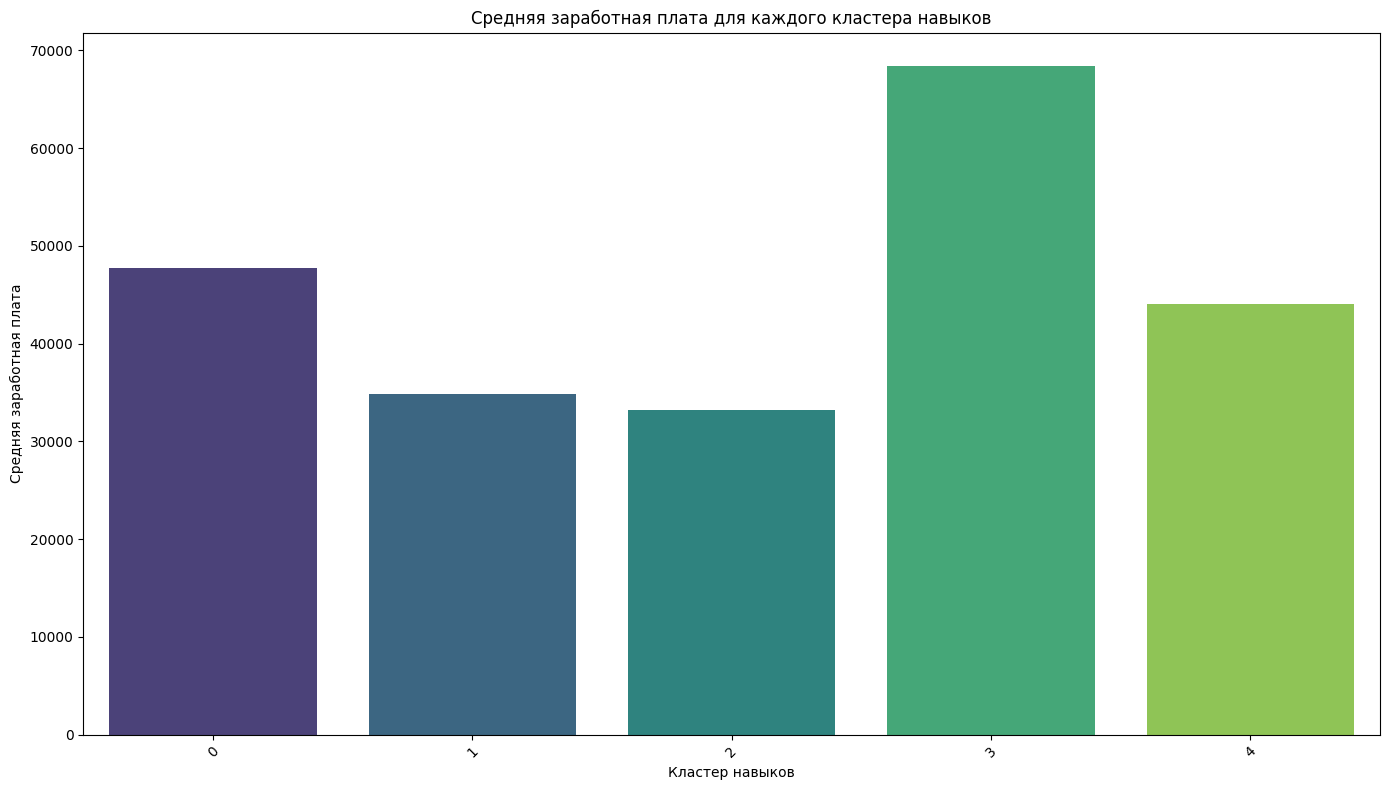

In [121]:
# Визуализация данных
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_salary_by_skills_sorted, x='cluster', y='avg_salary', palette='viridis')
plt.title('Средняя заработная плата для каждого кластера навыков')
plt.xlabel('Кластер навыков')
plt.ylabel('Средняя заработная плата')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [122]:
# Получение частоты встречаемости каждого кластера навыков
cluster_freq = result['cluster'].value_counts()

# Вывод частоты встречаемости каждого кластера навыков
print("Частота встречаемости каждого кластера навыков:")
print(cluster_freq)

Частота встречаемости каждого кластера навыков:
1    3057
0    1953
4    1030
2     871
3     493
Name: cluster, dtype: int64


Частота встречаемости каждого кластера навыков:
   cluster  frequency
0        1       3057
1        0       1953
2        4       1030
3        2        871
4        3        493


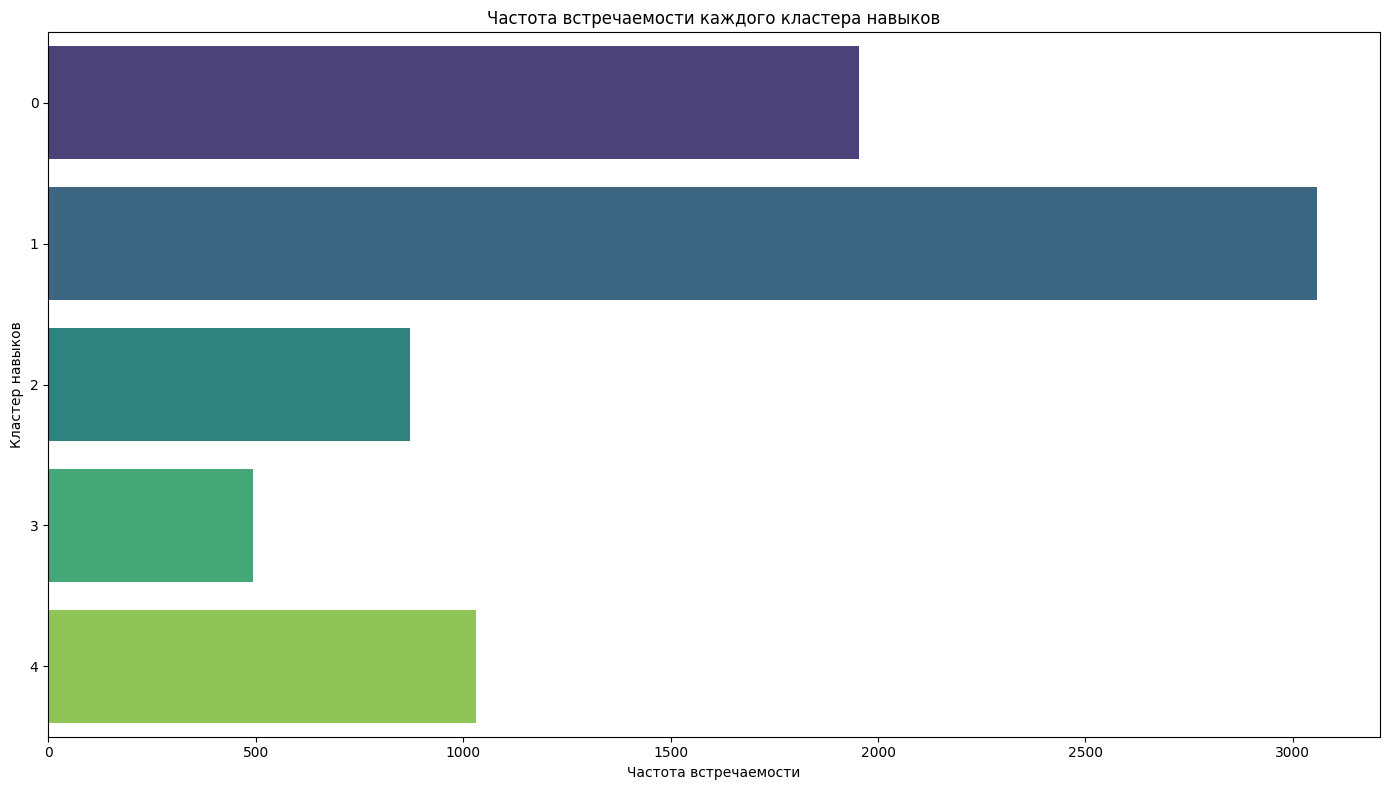

In [126]:
# Преобразование в DataFrame для удобства визуализации
cluster_freq_df = cluster_freq.reset_index()
cluster_freq_df.columns = ['cluster', 'frequency']

# Вывод частоты встречаемости каждого кластера навыков
print("Частота встречаемости каждого кластера навыков:")
print(cluster_freq_df)

# Визуализация данных
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_freq_df, x='frequency', y='cluster', palette='viridis', orient='h')
plt.title('Частота встречаемости каждого кластера навыков')
plt.xlabel('Частота встречаемости')
plt.ylabel('Кластер навыков')
plt.tight_layout()
plt.show()

In [127]:
# Получение доли каждого кластера навыков от общего количества вакансий
cluster_share = result['cluster'].value_counts(normalize=True)

# Вывод доли каждого кластера навыков от общего количества вакансий
print("Доля каждого кластера навыков от общего количества вакансий:")
print(cluster_share)

Доля каждого кластера навыков от общего количества вакансий:
1    0.412885
0    0.263776
4    0.139114
2    0.117639
3    0.066586
Name: cluster, dtype: float64


Выше можно убедиться в этих данных на графике.

Самые часто встречающиеся навыки в каждом кластере

In [130]:
# Создадим словарь, где ключ - номер кластера, а значение - список текстов (навыков) из этого кластера
clusters_text = {cluster: result.loc[result['cluster'] == cluster, 'text_lemm'].tolist() for cluster in result['cluster'].unique()}

# Для каждого кластера найдём топ-10 самых часто встречающихся слов (навыков)
for cluster, texts in clusters_text.items():
    print(f"Cluster {cluster}:")

    # Создадим CountVectorizer для текстов в текущем кластере
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(texts)

    # Найдем сумму вхождений каждого слова во все тексты текущего кластера
    sum_words = X.sum(axis=0)

    # Найдем индексы топ-10 самых часто встречающихся слов в текущем кластере
    top_indices = sum_words.argsort()[-10:][::-1]

    # Найдем соответствующие слова и их частоту встречаемости
    top_words = [(vectorizer.get_feature_names_out()[i], sum_words[0, i]) for i in top_indices]

    # Выведем результаты
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print()


Cluster 0:
[['орган' 'программный' 'профессиональный' 'прохождение' 'процентный'
  'firebase' 'процессный' 'etl' 'разметка' 'размещение' 'рассылка'
  'enterprise' 'микроконтроллер' 'git' 'effects' 'suite' 'релиз'
  'development' 'superset' 'ретушь' 'customer' 'измерительный' 'зарплата'
  'tilda' 'collector' 'chemcad' 'скорость' 'инструмент' 'соблюдение'
  'приложение' 'прибор' 'микропроцессор' 'монтаж' 'мотивировать' 'nosql'
  'movie' 'mongodb' 'php' 'маркировка' 'обслуживание' 'mathcad'
  'особенность' 'логический' 'scada' 'maker' 'lightroom' 'premiere' 'pro'
  'key' 'кредитный' 'печать' 'контролировать' 'qwery' 'indesign' 'поток'
  'пресс' 'hcm' 'magento' 'сообщение' 'интерпретация' 'выставка'
  'autocad' 'техника' 'автоматизированный' 'адаптировать' 'architect'
  'arcgis' 'appsflyer' 'гарантия' 'трафик' 'теплоснабжение' 'активность'
  'фотография' 'видеосъёмка' 'after' 'видео' 'adfox' 'арбитраж' 'аренда'
  'архив' 'ассемблер' 'учебный' 'windows' 'метрологический' 'страхование'
  'ди

почему то выводятся все навыки, но главное что они отсортированы и можно посмотреть часто встречающиеся навыки.

Топ навыков по встречаемости в каждом кластере

0 кластер - орган, программный, процессный, прохождение, системный, приложение, разметка, рассылка, etl, микроконтроллер.

1 кластер - указать, не указано

2 кластер - dynamics, внимательность, операционный, взаимодействие, devops

3 кластер - язык, 1c, внимательность, английский, docs

4 кластер - процессный, финанс, качество, клиентоориентированность, контроль, docker

## 3.7. Файл в формате xlsx

Теперь сохраним нашу таблицу с частотой, содержанием и классом навыков в файл Excel для работы с графами в следующем модуле.

In [131]:
# Сохраняем таблицу с частотой, содержанием и классом навыков в файл Excel с учетом кодировки
skills_freq_table.to_excel('table_skills.xlsx', index=False)

# Итоги

В результате мы спарсили ещё почти 2к вакансий и добавили их к существующим. Смогли сделать семантический анализ текста. Построили облако слов. Обучили несколько моделей для векторизации. Вывели и посмотрели на топики. Сделали систему для поиска ключевых навыков по топикам. Сделали кластеризацию. Сделали классификацию. Определили группы навыков.

Полученные группы навыков такие:

В итоге у нас получилось пять групп навыков:
1. Навыки которые тесно связаны с разработкой и управлением различных систем (кластер 0)
2. Навыки которые не указали работодатели (кластер 1)
3. Навыки которые связаны с работой с базами данных SQL (кластер 2)
4. Навыки которые связаны с 1C разработкой (кластер 3)
5. Навыки которые тесно связаны с bpmn и организацией и управлением биз (кластер 4)